In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("C:/Users/Bhavika/OneDrive/Desktop/practice/behaviour_simulation_train2.csv",encoding='cp1252')

# what to do---
-->Step 1- fill the missing value.
-->Step 2- to find the sentiment value
-->encoding the str to float
-->put the feature in model and train it
-->take log1p(y_test) for better accuracy
-->for checking the element of each column i used the m notnull().all
-->Then by train-test split train the model by 80% by train and 20 % by test and will get the result.
-->use the different method of training of model  eg linear regression, xgboost or feature enginnering.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from textblob import TextBlob

df = df.drop(columns=['id'], errors='ignore')
df['content'] = df['content'].fillna("")
df['media'] = df['media'].fillna("unknown")
df['username'] = df['username'].fillna("unknown")
df['inferred company'] = df['inferred company'].fillna("unknown")

df['sentiment'] = df['content'].apply(lambda x: TextBlob(x).sentiment.polarity)

df['char_count'] = df['content'].apply(len)
cat_features = ['media', 'username', 'inferred company']
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded = encoder.fit_transform(df[cat_features])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_features))
X = pd.concat([df[['sentiment', 'char_count']], encoded_df], axis=1)
y = np.log1p(df['likes'])

mask = X.notnull().all(axis=1) & np.isfinite(y)
X = X[mask]
y = y[mask]
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Train model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred_log = model.predict(X_test)
r2 = r2_score(y_test, y_pred_log)
rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_log)))

print("R² Score (log scale):", round(r2, 4))
print("RMSE (original scale):", round(rmse, 4))


In [4]:
from sklearn.preprocessing import OrdinalEncoder

df = df.drop(columns=['id'], errors='ignore')
df['content'] = df['content'].fillna("")
df['media'] = df['media'].fillna("unknown")
df['username'] = df['username'].fillna("unknown")
df['inferred company'] = df['inferred company'].fillna("unknown")
df['sentiment'] = df['content'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['char_count'] = df['content'].apply(len)
ord_encoder = OrdinalEncoder()
df[['media_enc', 'username_enc', 'company_enc']] = ord_encoder.fit_transform(
    df[['media', 'username', 'inferred company']]
)
X = df[['sentiment', 'char_count', 'media_enc', 'username_enc', 'company_enc']]
y = np.log1p(df['likes'])
mask = X.notnull().all(axis=1) & np.isfinite(y)
X = X[mask]
y = y[mask]


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred_log = model.predict(X_test)
# Evaluation
r2 = r2_score(y_test, y_pred_log)
rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_log)))
print("R² Score (log scale):", round(r2, 4))
print("RMSE (original scale):", round(rmse, 4))


R² Score (log scale): 0.0948
RMSE (original scale): 4872.8384


# XGBOOST FOR BETTER VALUE

In [6]:
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)
y_pred_log = model.predict(X_test)
# Evaluation
r2 = r2_score(y_test, y_pred_log)
rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_log)))
print("R² Score (log scale):", round(r2, 4))
print("RMSE (original scale):", round(rmse, 4))


R² Score (log scale): 0.8802
RMSE (original scale): 4438.9814


array([[<Axes: title={'center': 'likes'}>,
        <Axes: title={'center': 'sentiment'}>],
       [<Axes: title={'center': 'char_count'}>,
        <Axes: title={'center': 'media_enc'}>],
       [<Axes: title={'center': 'username_enc'}>,
        <Axes: title={'center': 'company_enc'}>]], dtype=object)

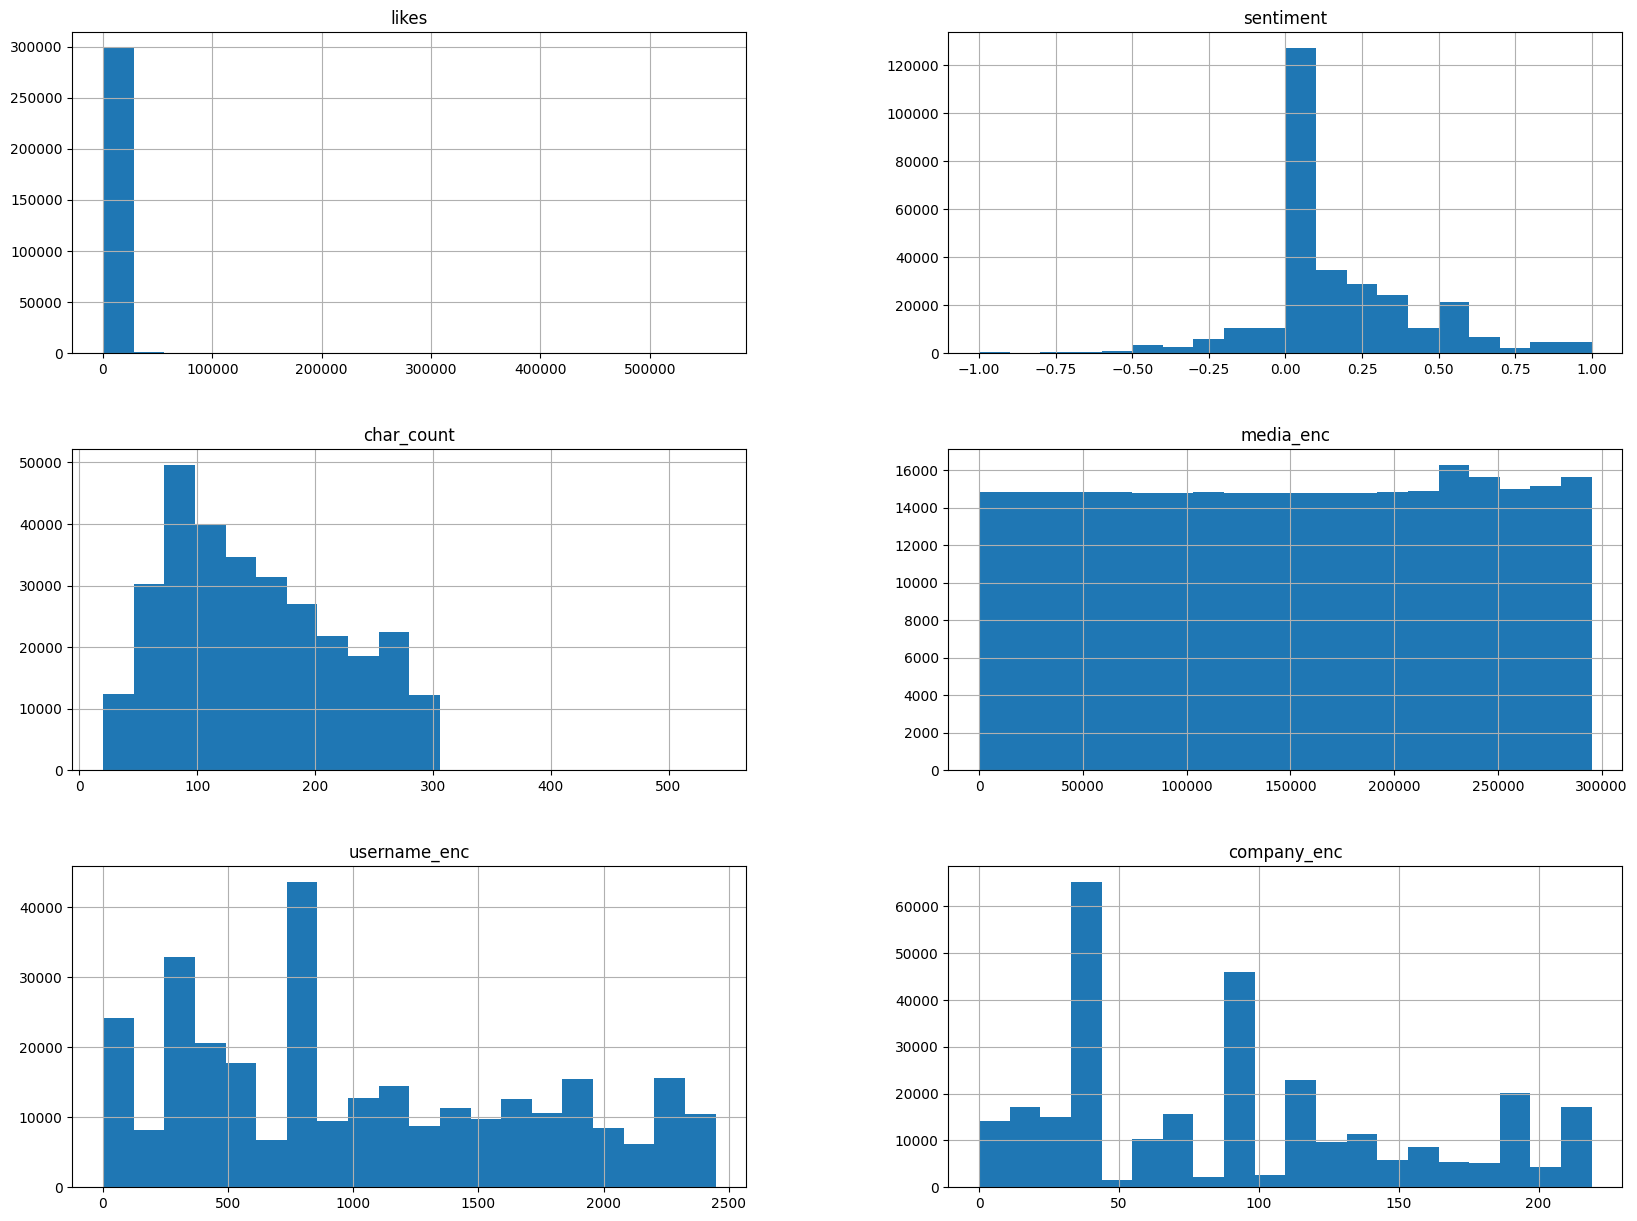

In [8]:
import seaborn as sns
df.hist(bins=20 , figsize=(20,15))

In [9]:
import joblib

In [11]:
joblib.dump(model, 'like_predictor_model.joblib')

['like_predictor_model.joblib']

In [14]:
joblib.dump(model, 'like_predictor_model.pk1')

['like_predictor_model.pk1']

In [18]:
from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import numpy as np
from textblob import TextBlob
model = joblib.load('like_predictor_model.pk1)
app_name = FastAPI()
class TweetData(BaseModel):
    content: str
    inferred_company: str
@app_name.post("/predict")
def predict_likes(data: TweetData):
    sentiment = TextBlob(data.content).sentiment.polarity
    char_count = len(data.content)
    company_map = {
        'CompanyA': 0,
        'CompanyB': 1,
        'CompanyC': 2,
    }
    company_encoded = company_map.get(data.inferred_company, 0)  # default to 0
    input_data = np.array([[sentiment, char_count, company_encoded]])
    log_pred = model.predict(input_data)[0]
    likes_pred = np.expm1(log_pred)
    
    return {"predicted_likes": int(likes_pred)}

# for api i used browser 